# **Numerical Experiments for Exact models**

In the discussion with Max, Andrea and Alexander on 9/3/2023, we decided to implement experiments for the numerical CLUE using exact models and checking how much can we reduce the system beyond the exact CLUE without losing too many information on the observables.

Given a model $\dot{x} = f(x)$, some initial condition $x_0$ and a time horizon $T$ have the following information:
* $||x_0||_2$: the size of the initial condition.
* $||f(x_0)||_2$: the size of the initial drift. This is the initial slope of the problem.

If we allow a maximal deviation $\delta ||f(x_0)||_2$ for a $\delta\in[0,1]$, we can compute the corresponding optimal threshold $\varepsilon(\delta)$ for which we compute the Approximate CLUE. This lumping has the following information:
* The lumping matrix $L$ where the number of rows is the size of the reduction.
* The average error on the observable(s) during a simulation until the time horizon $T$.
* The final error on the time horizon $T$ of the observables.

The goal on this section is to provide the code for performing these experiments in the most efficient way. Then we will proceed to move this into a script where results files will be generated that can be compiled into CSV files that will allow to extract the information for the article.

### Measuring the deviation

Given a system $\dot{x} = f(x)$, a compact domain $[0,C]^n$ and a matrix $L \in \mathbb{R}^{m\times n}$, we can define how far is $L$ to be a lumping by measuring the deviation of $L$ in $[0,C]^n$. The deviation of $L$ at a point $x_0 \in \mathbb{R}^n$ is defined by:
$$||Lf(L^+Lx_0) - Lf(x_0)||_2,$$
where $L^+$ is the pseudoinverse of $L$ (meaning $L$ need maximal rank $m$). If we compute the average deviation on $[0,C]^n$, we are computing the following quantity:
$$\text{dev}(L; f, C) = \frac{1}{C^n}\int_{[0,C]^n} ||Lf(L^+Lx) - Lf(x)||_2 dx.$$

In order to compute this average deviation, we can use a Monte-Carlo approach. We sample $N$ random points from $[0,C]^n$ uniformly distributed and then we compute the deviation of $L$ at those points. Then we average the result. It is well known that this quantity converges to $\text{dev}(L; f, C)$.

In [1]:
## Adding appropriate paths for loading examples
import sys, os

sys.path.insert(0,"./../tests/examples") # clue_example is here
sys.path.insert(0,"./../") # clue is here

from alive_progress import alive_bar
from clue import *
from clue.simulations import *
from clue_example import *
from math import ceil, log10
from numpy import array, matmul, sqrt
from numpy.linalg import pinv, norm, det
from scipy.optimize._optimize import OptimizeResult
from typing import Collection

import logging

logger = logging.getLogger("clue")
# logger.setLevel(logging.DEBUG)

In [2]:
def run_exact_test(example_name: str, # argument for name
                   percentage_slope: float | list[float] = 0.1, num_points: int = 50, threshold: float = 1e-6, # arguments for defining 
                   t0: float = 0.0, t1: float = 1.0, x0: Collection[float] = None, tstep: float = None,  # arguments for simulations
):
    ## Getting the example
    example = get_example(example_name)
    system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read)
    
    ## Obtaining the initial point and initial slope
    x0 = [float(system.ic.get(v, 0)) for v in system.variables] if x0 is None else x0; x0 = array(x0)
    norm_x0 = norm(x0, ord=2)
    fx0 = array([float(el) for el in system.derivative(_, x0)])
    norm_fx0 = norm(fx0, ord=2)
    
    ## Managing the time framework for simulations
    if t0 > t1: t0,t1 = t1,t0
    tstep = (t1-t0)/200 if tstep is None else tstep
                    
    ## Checking the percentage input
    if not isinstance(percentage_slope, (list,tuple)):
        percentage_slope = [percentage_slope]
    
    ## Creating observables
    observables = [[SparsePolynomial.from_string(s, system.variables, system.field) for s in obs_set] for obs_set in example.observables]
    
    ## Computing the true lumpings for each observable
    logger.info("[exact_test] Computing the exact lumpings...")
    lumped_systems = [system.lumping(obs_polys, method=example.matrix, print_system=False,print_reduction=False) for obs_polys in observables]
    logger.debug(f"[exact_test]  + Done! {[sys.size for sys in lumped_systems]}")
    
    ## Computing the epsilon for numerical lumping for each observable and each percentage
    C = max(max(abs(x0)),max(abs(fx0*(t0-t1)/2+x0))) ##### DECIDING THE BOUND FOR THE SAMPLES
    optimal_epsilons = []
    logger.info("[exact_test] Computing optimal epsilons for each observable...")
    for observable in observables:
        logger.debug(f"[exact_test] Computing optimal epsilons for {observable}...")
        epsilons = []
        for percentage in percentage_slope:
            max_dev = norm_fx0*percentage ##### DECIDING THE MAXIMAL DEVIATION
            logger.debug(f"[exact_test] Computing optimal epsilons for {observable}: {max_dev = }")
            epsilons.append(system.find_acceptable_threshold(observable, max_dev, 1, C, num_points, threshold))
        optimal_epsilons.append(epsilons)
        
    logger.info("[exact_test] Computing the numerical lumpings...")
    results = []
    for (observable, epsilons) in zip(observables, optimal_epsilons):
        for (percentage, epsilon) in zip(percentage_slope, epsilons):
            logger.debug(f"[exact_test] Computing numerical lumpings // {observable=} || {percentage=} || {epsilon=} \\\\")
            system.lumping_subspace_class = NumericalSubspace, {"delta":epsilon}
            lumped_system = system.lumping(observable, method=example.matrix, print_system=False, print_reduction=False)
            logger.debug(f"[exact_test] Computed // {observable=} || {percentage=} || {epsilon=} --> {lumped_system.size}\\\\")
            results.append((observable, norm_x0, norm_fx0, percentage, epsilon, lumped_system))
            
    ### TODO: add the computation of simulations and getting errors on observables in this method so the output provide all the data for the CSV
    ### maybe with some figures already
    ### Then, this will be put into the numerical test script and add the data for examples in the corresponding json.
    ### Implement then the output file for all the information for the CSV
    ### Implement the compilation of information
    ### Show the results for the rational cases.
            
    return results

In [ ]:
results = run_exact_test("ProteinPhosphorylation[2]", 
                percentage_slope = [10,15,20], 
                t1 = 0.00125)

In [9]:
system = FODESystem(file=get_example("ProteinPhosphorylation[2]").path_model(), read_ic = True, parser=get_example("ProteinPhosphorylation[2]").read)
x0 = array([float(system.ic.get(v, 0)) for v in system.variables])
t0 = 0; t1 = 0.00125; tstep = (t1-t0)/200

In [11]:
x0.dtype

dtype('float64')

In [21]:
results[0]

([S0, S1],
 3029.8630315576975,
 1992234.925906079,
 10,
 1.649916648864746,
 Lumped system [24 -> 10] (e2) [LDESystem -- 10 -- Add])

In [15]:
lsystem = results[0][-1]
Lx0 = matmul(lsystem.lumping_matrix.to_numpy(dtype=x0.dtype), x0)
O = SparseRowMatrix.from_vectors([poly.linear_part_as_vec() for poly in results[0][0]])

[ 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]
[ 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]


In [44]:
true_sim = apply_matrix(system.simulate(t0,t1,x0,tstep), O)
appr_sim = apply_matrix(lsystem.simulate(t0,t1,Lx0,tstep), O.matmul(lsystem._subspace.pinv()))
appr_sim.names = [f"{name}[{results[0][-2]} -- {results[0][3]}]" for name in true_sim.names]

In [46]:
from scipy.integrate._ivp.ivp import OdeResult
diff_sim = OdeResult(**true_sim)
diff_sim.y = abs(true_sim.y - appr_sim.y)

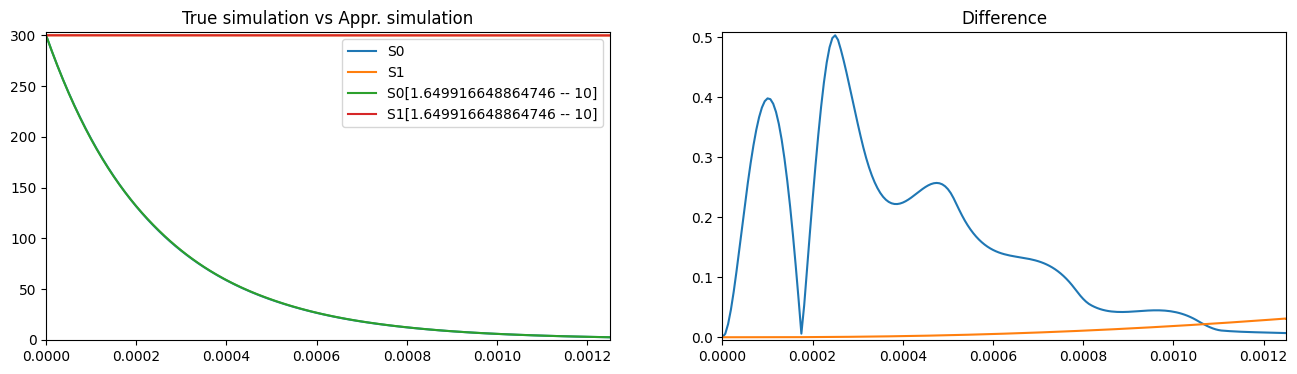

In [47]:
create_figure([merge_simulations(true_sim, appr_sim), diff_sim], format=["-", "-"], title=["True simulation vs Appr. simulation", "Difference"]);

# **Tests for Numerical CLUE**

In this notebook we are going to test out (with several examples) how the implementation of numerical CLUE works on different type of examples:

* Basic polynomial examples (for shake of testing the code)
* Rational examples (this will be an improvement from the ERODE current implementation)

For each of the models we are going to perform several tests:

- With the **exact model**: 
  * We increase the $\delta$ threshold slowly until we aggregate everything together. This produces two different graphical values:
    1. Given $\delta$, the number of reduced species. 
    2. Given $\delta$, the error of the observed species.
- We **perturb the model** using a small random noise:
  * We check if we manage to obtain the original reduction for some $\delta$.
  * We check if the observed quantity is close to the **true** value.
  
Since we need to perform similar runs for different models, the notebook will start with a section dedicated to set up generic functions to run each of the tests. Then, further sections will run these generic functions for specific models with small comments on the results.


## 1. Generic testing functions

In [3]:
def run_exact_test(example_name: str, # argument for name
                   init_delta: float = 0.0, increase_delta: float = 0.1, # arguments for evolution on delta
                   t0: float = 0.0, t1: float = 1.0, x0: Collection[float] = None, tstep: float = None,  # arguments for simulations
                   measure="l2avg" # measure to be use for errors
):
    ## Processing the input
    increase_log10 = log10(increase_delta)
    if increase_log10 < 0: # the increase is smaller than 1
        rounding = ceil(-increase_log10)
    else: # the increase is bigger than 1
        rounding = 2
    
    ## Getting the example
    example = get_example(example_name)
    system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read)
    
    ## Creating observables
    observables = [[SparsePolynomial.from_string(s, system.variables, system.field) for s in obs_set] for obs_set in example.observables]
    
    ## Computing the true lumpings for each observable
    logger.debug("[exact_test] Computing the exact lumpings...")
    lumped_systems = [system.lumping(obs_polys, method=example.matrix, print_system=False,print_reduction=False) for obs_polys in observables]
    logger.debug(f"[exact_test]  + Done! {[sys.size for sys in lumped_systems]}")
    
    logger.debug("[exact_test] Computing the numerical lumpings...")
    delta = init_delta; increase = increase_delta; key = None
    numerical_lumpings = dict()
    while len(numerical_lumpings) == 0 or any(numerical_lumpings[key][i].size > len(example.observables[i]) for i in range(len(numerical_lumpings[key]))):
        key = round(delta, rounding)
        logger.debug(f"[exact_test]  - Running case with {delta=}...")
        num_system = FODESystem(file=example.path_model(), parser=example.read, lumping_subspace=NumericalSubspace, lumping_subspace_kwds={"delta": delta})
        numerical_lumpings[key] = [num_system.lumping(obs_polys, method=example.matrix, print_system=False, print_reduction=False) for obs_polys in observables]
        logger.debug(f"[exact_test]  + Done!! {[sys.size for sys in numerical_lumpings[key]]}")
        delta += increase
    logger.debug("[exact_test] Done numerical lumpings")
    
    ## Producing the graph for size reduction
    deltas = list(numerical_lumpings.keys())
    names = [str(obs_polys) for obs_polys in observables]
    sizes = [[numerical_lumpings[delta][i].size for delta in deltas] for i in range(len(names))]
    delta_vs_size = OptimizeResult(t=array(deltas), y=array(sizes)/num_system.size, names=names, success=True)
    
    ## producing the simulations
    if t0 > t1: t0,t1 = t1,t0
    x0 = [system.ic.get(v, 0) for v in system.variables] if x0 is None else x0; x0 = array(x0)
    tstep = (t1-t0)/200 if tstep is None else tstep
    
    logger.debug("[exact_test] Computing simulation for real system...")
    real_simulation = system.simulate(t0, t1, x0, tstep)
    observables_matrices = [SparseRowMatrix.from_vectors([poly.linear_part_as_vec() for poly in obs]) for obs in observables]
    real_obs_alone = [apply_matrix(real_simulation, O) for O in observables_matrices]
    
    numerical_errors = dict()
    for delta in numerical_lumpings:
        logger.debug(f"[exact_test]  - Computing simulation for {delta=}...")
        errors = []
        for i, O in enumerate(observables_matrices):
            lsystem = numerical_lumpings[delta][i]
            lx0 = matmul(lsystem.lumping_matrix.to_numpy(), x0)
            numerical_sim = lsystem.simulate(t0,t1,lx0,tstep)
            numerical_sim = apply_matrix(numerical_sim, O.matmul(lsystem._subspace.pinv()))
            comparison = compare_simulations(real_obs_alone[i], numerical_sim, measures=measure)
            errors.append(norm(comparison[1][0]))
        numerical_errors[delta] = errors
        
    errors = array([[numerical_errors[delta][i] for delta in numerical_errors] for i in range(len(names))])
    delta_vs_error_obs = OptimizeResult(t=array(deltas), y=array(errors), names=names, success=True)
        
        
    return (system, lumped_systems, numerical_lumpings), (delta_vs_size, delta_vs_error_obs)

In [4]:
def run_perturbed_case(example_name: str, # argument for name
                   noise: str = "normal", amplitude: float = 0.05, num_samples: int = 50, # arguments for perturbing the model
                   dev_max: float = 1., increment: float = 0.1, bound: float = None, num_points: int = 100, threshold: float = 0.001,
                   t0: float = 0.0, t1: float = 1.0, x0: Collection[float] = None, tstep: float = None # arguments for simulations
):
    ## Getting the example
    example = get_example(example_name)
    system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read)
    ## Creating observables
    observables = [[SparsePolynomial.from_string(s, system.variables, system.field) for s in obs_set] for obs_set in example.observables]
    
    ## Processing some arguments depending on the model
    if bound is None:
        bound = max((abs(v) for v in system.ic.values()), default=0)
        bound = 1.0 if bound == 0 else bound
        
    if t0 > t1: t0,t1 = t1,t0
    x0 = [system.ic.get(v, 0) for v in system.variables] if x0 is None else x0; x0 = array(x0)
    tstep = (t1-t0)/200 if tstep is None else tstep
    
    ## Computing the true lumpings for each observable
    logger.debug("[perturbed_test] Computing the exact lumpings...")
    lumped_systems = [system.lumping(obs_polys, method=example.matrix, print_system=False,print_reduction=False) for obs_polys in observables]
    logger.debug(f"[perturbed_test]  + Done! {[sys.size for sys in lumped_systems]}")
    
    num_lumpings = []
    for i in range(num_samples):
        logger.debug(f"[perturbed_test] Starting experiment {i}:")
        perturbed = system.PerturbedFromSystem(system, noise, amplitude)
        results = []
        for obs_polys in observables:
            logger.debug(f"[perturbed_test] Computing optimal threshold for observables {obs_polys}...")
            epsilon = perturbed.find_acceptable_threshold(obs_polys, dev_max, increment, bound, num_points, threshold)
            perturbed.lumping_subspace = (NumericalSubspace, {"delta": epsilon})
            logger.debug(f"[perturbed_test] Lumping with {epsilon = }")
            results.append(perturbed.lumping(obs_polys, method=example.matrix, print_system=False, print_reduction=False))
            
    
    logger.debug(f"[perturbed_test] Completed all lumping computations")
    ## Now we compute the error make in the simulation for the observables
    logger.debug("[perturbed_test] Computing simulation for real system...")
    real_simulation = system.simulate(t0, t1, x0, tstep)
    observables_matrices = [SparseRowMatrix.from_vectors([poly.linear_part_as_vec() for poly in obs]) for obs in observables]
    real_obs_alone = [apply_matrix(real_simulation, O) for O in observables_matrices]
    
    logger.debug("[perturbed_test] Computing simulation for perturbed numerical lumpings...")
    
    simulations_for_observable = [] # list with all the errors for each observable
    for i in range(len(observables)):
        logger.debug(f"[perturbed_test] Computing perturbed simulations for observables {observables[i]}")
        perturbed_sims = []
        for j in range(num_samples):
            lsystem = num_lumpings[j][i]; O = observables_matrices[i]
            
            numerical_sim = lsystem.simulate(t0,t1,lx0,tstep)
            perturbed_sims.append(apply_matrix(numerical_sim, O.matmul(lsystem._subspace.pinv())))
        
        logger.debug(f"[perturbed_test] Computing average and standard error of the mean for these simulations")
        all_data = array([simulation.y for simulation in perturbed_sims]) # ndarray with shape on (sample, observable, time)
        averages = all_data.mean(0)
        sem = all_data.std(0)/numpy.sqrt(num_samples)
        
        ## Creating the three new simulations: average, average + sem, average - sem
        kwds = {key : real_obs_alone.__getattr__(key) for key in dir(simulation)}
        kwds.pop("y",None)
        kwds.pop("names", None)
        
        if hasattr(real_obs_alone, "names"):
            avg_names = [f"AVG({dev_max}) {name}" for name in real_obs_alone.names]
            avgSem_names = [f"AVG+SEM({dev_max}) {name}" for name in real_obs_alone.names]
            avg_sem_names = [f"AVG-SEM({dev_max}) {name}" for name in real_obs_alone.names]
        else:
            avg_names, avgSem_names, avg_sem_names = None, None, None
        avg_sim = OdeResult(**kwds, y = averages, names = avg_names)
        avgSem_sim = OdeResult(**kwds, y = averages + sem, names = avgSem_names)
        avg_sem_sim = OdeResult(**kwds, y = averages - sem, names = avg_sem_names)
        simulations_for_observable.append([real_obs_alone[i], avg_sim, avgSem_sim, avg_sem_sim])
        
    return system,list(zip(observables),simulations_for_observable)        

In [3]:
(system, lumped, numerical), graphs = run_exact_test("ProteinPhosphorylation[2]", 1.5, 0.1, t0=0.0, t1=0.00125)

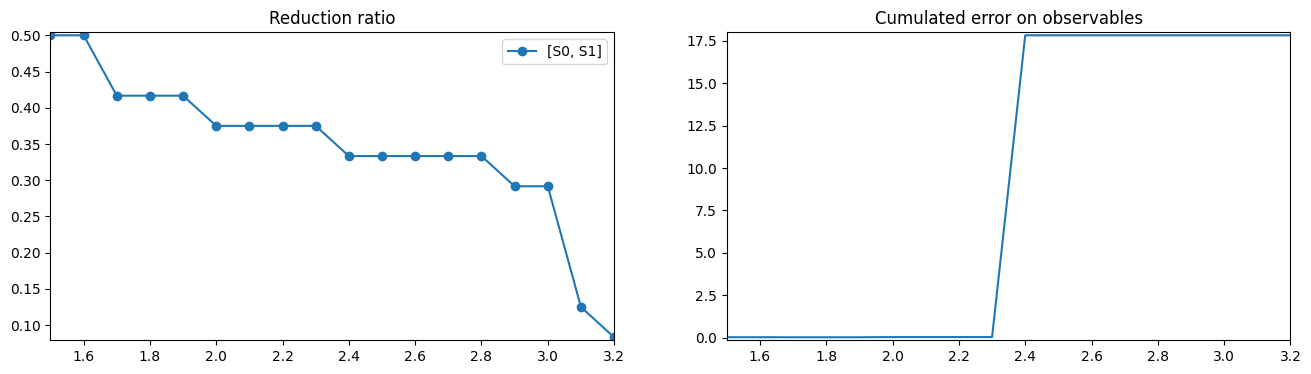

In [4]:
create_figure(graphs, title=["Reduction ratio", "Cumulated error on observables"], format=["-o", "-"]);

# 2. Rational examples (using exact model and increase threshold)

## 2.1 BIO...013

In [4]:
name, init_delta, increase_delta, t0, t1 = "BIOMD0000000013", 0, 0.1, 0.0, 1.0
(system, lumped, numerical), graphs = run_exact_test(name, init_delta, increase_delta, t0=t0, t1=t1)

In [ ]:
create_figure(graphs, title=["Reduction ratio", "Cumulated error on observables"], format=["-o", "-"]);

## 2.1 BIO...023

In [3]:
name, init_delta, increase_delta, t0, t1 = "BIOMD0000000023", 0, 0.1, 0.0, 1.0
(system, lumped, numerical), graphs = run_exact_test(name, init_delta, increase_delta, t0=t0, t1=t1)

2023-03-06 10:08:30 INFO     [exact_test] Computing the exact lumpings...
2023-03-06 10:08:33 INFO     [exact_test]  + Done! [11]
2023-03-06 10:08:33 INFO     [exact_test] Computing the numerical lumpings...
2023-03-06 10:08:33 INFO     [exact_test]  - Running case with delta=0...
2023-03-06 10:08:36 INFO     [exact_test]  + Done!! [11]
2023-03-06 10:08:36 INFO     [exact_test]  - Running case with delta=0.1...
2023-03-06 10:08:38 INFO     [exact_test]  + Done!! [11]
2023-03-06 10:08:38 INFO     [exact_test]  - Running case with delta=0.2...
2023-03-06 10:08:41 INFO     [exact_test]  + Done!! [11]
2023-03-06 10:08:41 INFO     [exact_test]  - Running case with delta=0.30000000000000004...
2023-03-06 10:08:44 INFO     [exact_test]  + Done!! [11]
2023-03-06 10:08:44 INFO     [exact_test]  - Running case with delta=0.4...
2023-03-06 10:08:47 INFO     [exact_test]  + Done!! [11]
2023-03-06 10:08:47 INFO     [exact_test]  - Running case with delta=0.5...
2023-03-06 10:08:50 INFO     [exact_t

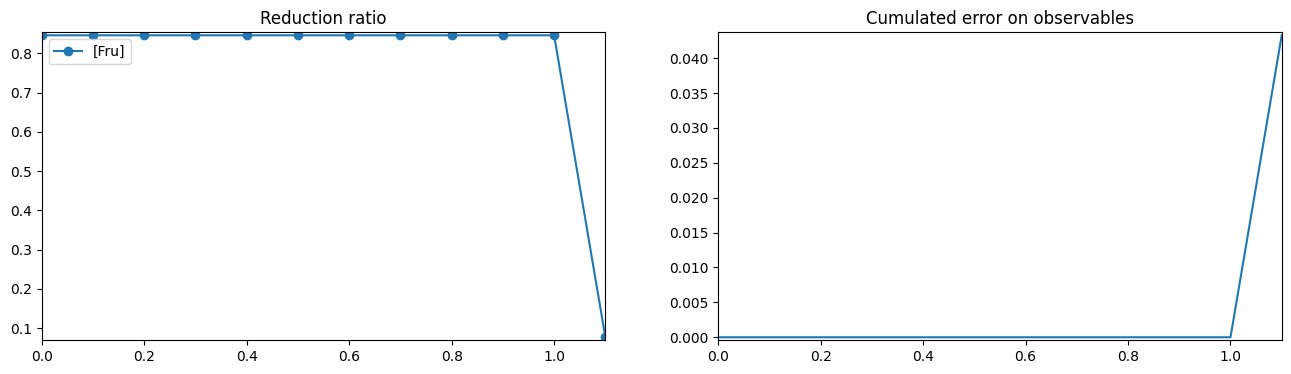

In [4]:
create_figure(graphs, title=["Reduction ratio", "Cumulated error on observables"], format=["-o", "-"]);

## 2.1 BIO...113

In [3]:
name, init_delta, increase_delta, t0, t1 = "BIOMD0000000113[sympy]", 0, 0.1, 0.0, 1.0
(system, lumped, numerical), graphs = run_exact_test(name, init_delta, increase_delta, t0=t0, t1=t1)

2023-03-06 10:22:11 INFO     [exact_test] Computing the exact lumpings...
2023-03-06 10:22:12 INFO     [exact_test]  + Done! [12]
2023-03-06 10:22:12 INFO     [exact_test] Computing the numerical lumpings...
2023-03-06 10:22:12 INFO     [exact_test]  - Running case with delta=0...
2023-03-06 10:22:12 INFO     [exact_test]  + Done!! [12]
2023-03-06 10:22:12 INFO     [exact_test]  - Running case with delta=0.1...
2023-03-06 10:22:13 INFO     [exact_test]  + Done!! [12]
2023-03-06 10:22:13 INFO     [exact_test]  - Running case with delta=0.2...
2023-03-06 10:22:13 INFO     [exact_test]  + Done!! [12]
2023-03-06 10:22:13 INFO     [exact_test]  - Running case with delta=0.30000000000000004...
2023-03-06 10:22:14 INFO     [exact_test]  + Done!! [12]
2023-03-06 10:22:14 INFO     [exact_test]  - Running case with delta=0.4...
2023-03-06 10:22:14 INFO     [exact_test]  + Done!! [12]
2023-03-06 10:22:14 INFO     [exact_test]  - Running case with delta=0.5...
2023-03-06 10:22:15 INFO     [exact_t

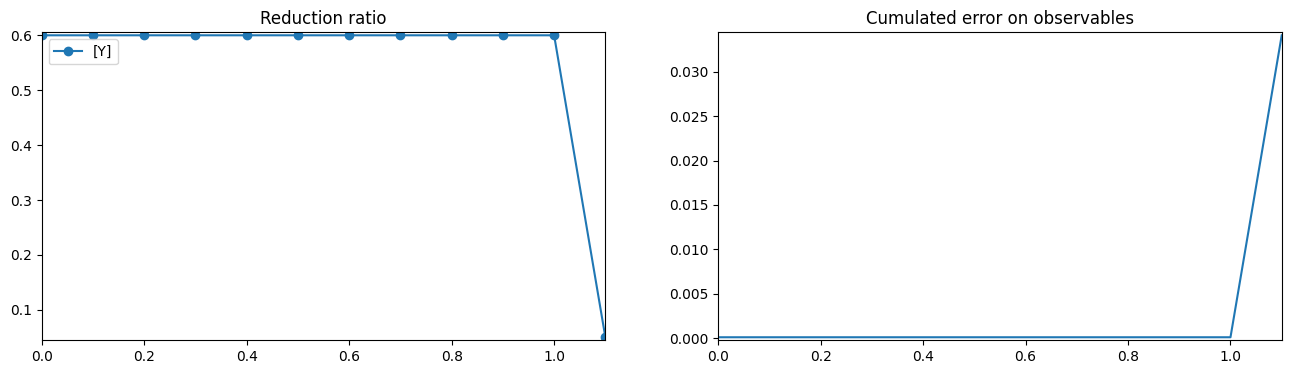

In [4]:
create_figure(graphs, title=["Reduction ratio", "Cumulated error on observables"], format=["-o", "-"]);

## 2.1 BIO...313

In [5]:
name, init_delta, increase_delta, t0, t1 = "BIOMD0000000313[sympy]", 0, 0.1, 0.0, 1.0
(system, lumped, numerical), graphs = run_exact_test(name, init_delta, increase_delta, t0=t0, t1=t1)

2023-03-06 10:25:34 INFO     [exact_test] Computing the exact lumpings...
2023-03-06 10:25:41 INFO     [exact_test]  + Done! [5]
2023-03-06 10:25:41 INFO     [exact_test] Computing the numerical lumpings...
2023-03-06 10:25:41 INFO     [exact_test]  - Running case with delta=0...
2023-03-06 10:25:47 INFO     [exact_test]  + Done!! [5]
2023-03-06 10:25:47 INFO     [exact_test]  - Running case with delta=0.1...
2023-03-06 10:25:54 INFO     [exact_test]  + Done!! [5]
2023-03-06 10:25:54 INFO     [exact_test]  - Running case with delta=0.2...
2023-03-06 10:26:00 INFO     [exact_test]  + Done!! [5]
2023-03-06 10:26:00 INFO     [exact_test]  - Running case with delta=0.30000000000000004...
2023-03-06 10:26:07 INFO     [exact_test]  + Done!! [5]
2023-03-06 10:26:07 INFO     [exact_test]  - Running case with delta=0.4...
2023-03-06 10:26:13 INFO     [exact_test]  + Done!! [5]
2023-03-06 10:26:13 INFO     [exact_test]  - Running case with delta=0.5...
2023-03-06 10:26:20 INFO     [exact_test]  

/home/anton/git/clue/notebooks/./../clue/simulations.py:193: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  a.title.set_text(title[i]); a.set_xlim(*xinterval[i]); a.set_ylim(*yinterval[i])


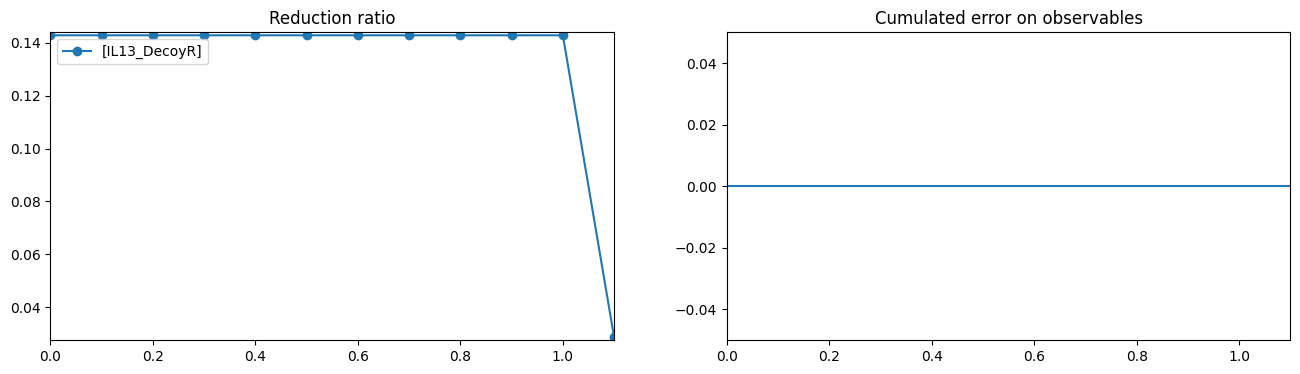

In [6]:
create_figure(graphs, title=["Reduction ratio", "Cumulated error on observables"], format=["-o", "-"]);

## 2.1 BIO...448

In [10]:
name, init_delta, increase_delta, t0, t1 = "BIOMD0000000448[sympy]", 0, 0.1, 0.0, 1.0
(system, lumped, numerical), graphs = run_exact_test(name, init_delta, increase_delta, t0=t0, t1=t1)

In [ ]:
create_figure(graphs, title=["Reduction ratio", "Cumulated error on observables"], format=["-o", "-"]);

## 2.1 BIO...526

In [8]:
name, init_delta, increase_delta, t0, t1 = "BIOMD0000000526[sympy]", 0, 0.1, 0.0, 1.0
(system, lumped, numerical), graphs = run_exact_test(name, init_delta, increase_delta, t0=t0, t1=t1)

2023-03-06 11:09:11 INFO     [exact_test] Computing the exact lumpings...
2023-03-06 11:09:18 INFO     [exact_test]  + Done! [19]
2023-03-06 11:09:18 INFO     [exact_test] Computing the numerical lumpings...
2023-03-06 11:09:18 INFO     [exact_test]  - Running case with delta=0...
2023-03-06 11:09:25 INFO     [exact_test]  + Done!! [19]
2023-03-06 11:09:25 INFO     [exact_test]  - Running case with delta=0.1...
2023-03-06 11:09:32 INFO     [exact_test]  + Done!! [19]
2023-03-06 11:09:32 INFO     [exact_test]  - Running case with delta=0.2...
2023-03-06 11:09:40 INFO     [exact_test]  + Done!! [19]
2023-03-06 11:09:40 INFO     [exact_test]  - Running case with delta=0.30000000000000004...
2023-03-06 11:09:47 INFO     [exact_test]  + Done!! [19]
2023-03-06 11:09:47 INFO     [exact_test]  - Running case with delta=0.4...
2023-03-06 11:09:54 INFO     [exact_test]  + Done!! [19]
2023-03-06 11:09:54 INFO     [exact_test]  - Running case with delta=0.5...
2023-03-06 11:10:02 INFO     [exact_t

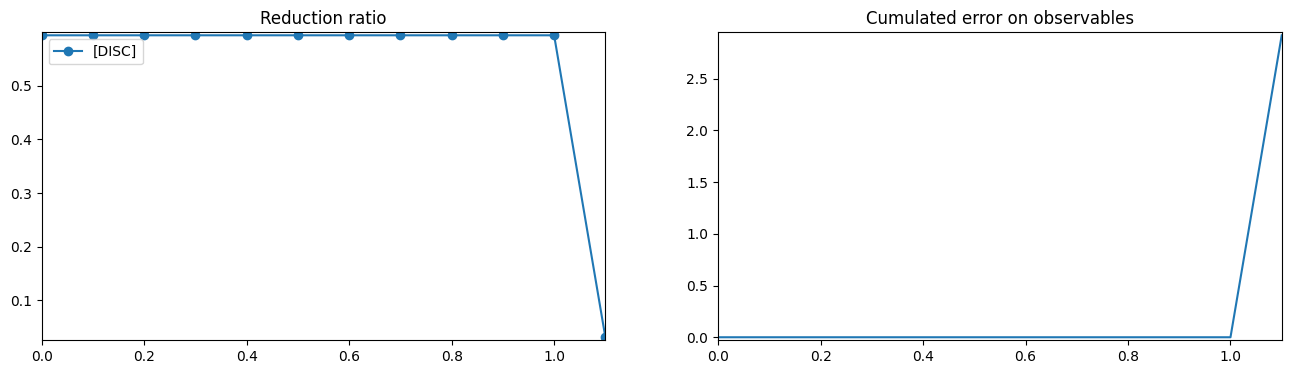

In [9]:
create_figure(graphs, title=["Reduction ratio", "Cumulated error on observables"], format=["-o", "-"]);

# 3. Rational examples (from perturbed model)